### 1. Conceptual questions [15]

#### 1. (5 points) Please prove the first principle component direction v corresponds to the largest eigenvector of the sample covariance matrix.

--ANS:  Please see 001.jpg and 002.jpg in data folder

(![title](0001.jpg) or Image methid does not work)

In [253]:
from IPython.display import Image

Image(url='0001.jpg', width=600, height=900)

print("Please see 0001.jpg and 002.jpg in data")


In [254]:
Image(url='0002.jpg', width=600, height=900)

![title](0001.jpg)
print("Please see 1-2-1.jpg and 1-2-2.jpg in data")

![title](0002.jpg)

#### (5 points) What is the relationship between SVD and eigendecomposition? Please explain this mathematically,and touch on why this is relevant for PCA.

--ANS:  Please see 1-2-1.jpg and 1-2-2.jpg in data folder

![title](1-2-1.jpg)

![title](1-2-2.jpg)

#### (5 points) Explain the three key ideas in ISOMAP (for manifold learning and non-linear dimensionality reduction).

ISOMAP is another method of dimension reduction that preserve the "walking distance" between points over the data cloud(manifold) following below 3 key steps/ideas -

1. Finding neighbors of each data point within a threshold and building as adjacency matrix recording "euclidean" distance
2. Finding shortest path distance matrix D between each pair of points form A
3. Finally finding low-dimensional representation which preserves teh distance information in D

### 2. Eigenfaces and simple face recognition [42 points; including 2 bonus points.] 

In [203]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob
from skimage.transform import rescale, resize, downscale_local_mean
import time

Size of faceimages : 21


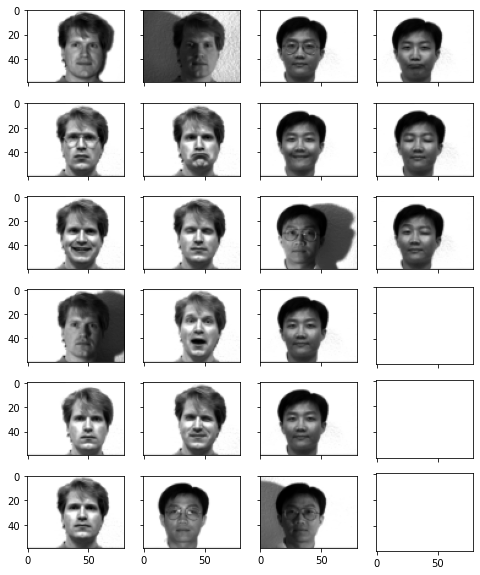

In [204]:
# load images in a dictionary 
# optionally visualize them
faces={}

for facepic in glob.glob('data'+os.path.sep+'yalefaces'+os.path.sep+'*.gif'):
    with Image.open(facepic) as im:
        # reszie / dpwnsample to 1/4th , you can take every 4th point
        faces[facepic] = resize(np.asarray(im),(np.asarray(im).shape[0]//4,np.asarray(im).shape[1]//4))
        
        
faceimages=list(faces.values())   
print(f"Size of faceimages : {len(faceimages)}")
faceshape=faceimages[0].shape
fig,axes = plt.subplots(nrows=6,ncols=4,sharex=True,sharey=True, figsize=(8,10))
for i in range(0,21):    
    axes[i%6][i//6].imshow(faceimages[i], cmap="gray")

plt.show() 
    #print(f"image shape is :{faceimages[i].shape}")
   
    

In [205]:
# keep test images in faceTest , and remove theem from training set
faceTest={k:v for k,v in faces.items() if 'test' in k}
_=[faces.pop(k) for k in faceTest.keys()]

In [206]:
# 
facematrix=[v.flatten() for v in faces.values()]
from sklearn.decomposition import PCA
pca = PCA().fit(facematrix)

In [207]:
print(facematrix[0].shape)
print(sum(pca.explained_variance_ratio_))

(4800,)
1.0000000000000002


In [208]:
print(pca.explained_variance_ratio_)

[5.33508078e-01 1.98967041e-01 1.30997550e-01 3.55932595e-02
 3.28686480e-02 2.24942704e-02 1.07846751e-02 9.00688549e-03
 7.18512179e-03 4.07361557e-03 3.48093877e-03 2.74939328e-03
 2.16436846e-03 1.93237726e-03 1.72634988e-03 1.37651151e-03
 1.09091662e-03 3.02791420e-31 1.60031720e-35]


#### plot of eigenfaces

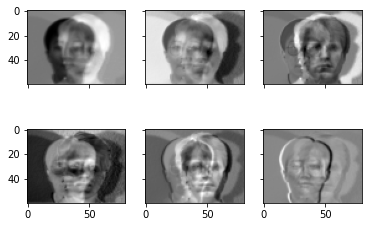

In [209]:

faceshape=faceimages[0].shape
eigenfaces = pca.components_[:6] # pick top six components
fig, axes = plt.subplots(2,3,sharex=True,sharey=True)
for i in range(6):
    axes[i%2][i//2].imshow(eigenfaces[i].reshape(faceshape), cmap="gray")
plt.show()

#### Observation :
each eigenfaces seems is culmination of attributes from other pictutres , and graphically looks a superimpose of individual pictures. From vectors with corresponding highest eigenvalues to less , the eigenfaces look to carry less attributes

In [210]:
# Generate weights as a KxN matrix where K is the number of eigenfaces and N the number of samples
weights = eigenfaces @ (facematrix - pca.mean_).T

In [211]:
eigenfaces.shape

(6, 4800)

Best match with Euclidean distance 6.089243


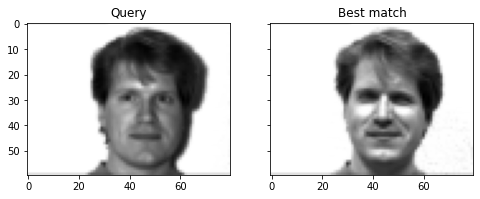

Best match with Euclidean distance 2.272503


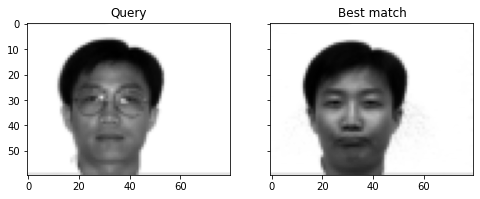

In [212]:
# Test on out-of-sample image of existing class

for k,v in faceTest.items():
    query = v.reshape(1,-1)
    query_weight = eigenfaces @ (query - pca.mean_).T
    euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
    best_match = np.argmin(euclidean_distance)
    print("Best match with Euclidean distance %f" % (euclidean_distance[best_match]))
    # Visualize
    fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
    axes[0].imshow(query.reshape(faceshape), cmap="gray")
    axes[0].set_title("Query")
    axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
    axes[1].set_title("Best match")
    plt.show()

#### (c) (Bonus: 2 points) Explain if eigenface facial recognition can work well, and discuss how it can be improved.
generally speaking, all the vectors corresponding eigenvalues carry the information of all dimension calollectively , with vectors corresponing to highest eigen value. 
So if we increase the number of eigenfaces in , theoratically will improve the match while reducing the performance

### 3. Order of faces using ISOMAP [45 points]

In [213]:
from scipy.io import loadmat
import numpy as np
import os
import matplotlib.image as mpimg
%matplotlib inline
file=r'data'+os.path.sep+os.path.sep+'isomap.mat'
raw_data=loadmat(file)
raw_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'images'])

In [214]:
data= raw_data['images']

In [215]:
data=data.T
data.shape

(698, 4096)

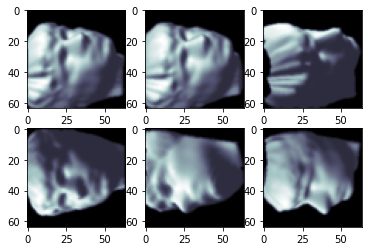

In [216]:
#sample original pic
fig,axes=plt.subplots(2,3)
for i in range(6):
    #print(f"shape is : {data[i].shape}")
    axes[i%2][i//2].imshow(data[i,:].reshape(64,64),cmap='bone')

In [217]:
# pairwise-distance metrics calculation function

from scipy.spatial.distance import cdist,pdist,squareform
from sklearn.utils.graph_shortest_path import graph_shortest_path

def distance_matrix(X, metric='euclidean'):
    return squareform(pdist(X,metric=metric))

In [218]:
#adjacency metrics calculation , considering the epsilon value

def adj_matrix(X,d,eps=1):
    m,n =X.shape # rows are data sample, columns are dimensions
    
    A=np.zeros((m,m)) + np.inf
    is_neighbor= d < eps
    A[is_neighbor]=d[is_neighbor]
    
    short= graph_shortest_path(A)
    return short

In [219]:
m,n=data.shape
A=np.zeros((m,m)) + np.inf

In [220]:
short= graph_shortest_path(A)

In [221]:
short

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [222]:
from numpy import linalg
def isomap(d, dim=2):
    """

    """

    n, m = d.shape
    h = np.eye(m) - (1/m)*np.ones((m, m)) # centering matrix
    d = d**2
    c = -1/(2*m) * h.dot(d).dot(h)        #covariance metrics formula
    
    #c = -.5 * h.dot(d).dot(h)        #covariance metrics formula
    
    evals, evecs = linalg.eig(c)
    idx = evals.argsort()[::-1]
    evals = evals[idx]   # sort the eigens , from largest to smallest
    evecs = evecs[:, idx]
    evals = evals[:dim]  # pick only 2 vectors and values
    evecs = evecs[:, :dim]
   
    z = evecs.dot(np.diag(evals**(-1/2))) # formula 

    return z.real

In [223]:
#call to build pairwise-dist matrix
d=distance_matrix(data)

In [224]:
np.max(d)

34.687168481791545

In [225]:
"""Step 1 & 2 : build the adjacency metrics, basically compare each calculated distance with epsilon, 
to see if they are neighbors. 
Once meighbors are identified, run shortest path algorithm - so actual walking distance between points
are recorded - not euclidean in space
"""
A=adj_matrix(data,d,eps=15) # based on distance and epsilon bound
A.shape

(698, 698)

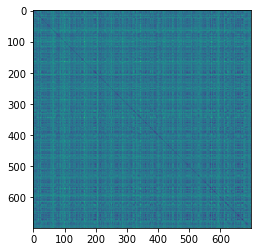

In [226]:
plt.imshow(A,)

In [227]:
# import networkx as nx

# G=nx.from_numpy_matrix(A)
# nx.draw(G,)
# plt.show()

In [228]:
"""3. Now as we have found shortest path adjacency, we can build the isomap"""
z=isomap(A)

In [229]:
z.shape[0]

698

In [230]:
z[0]

array([0.00259955, 0.00012483])

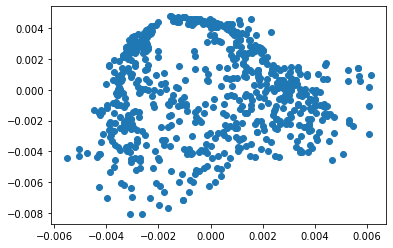

In [231]:
# plot for principal compnent projection of every point
plt.scatter(z[:,0],z[:,1])

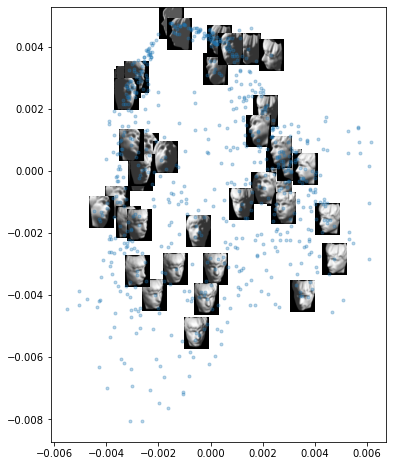

In [232]:
x_size = (max(z[:, 0]) - min(z[:, 0])) *.08
y_size = (max(z[:, 1]) - min(z[:, 1])) *.08

fig = plt.figure()
fig.set_size_inches(6,8)

ax=fig.add_subplot()


for i in range(40):
    x0 = z[i, 0] - (x_size / 2.)
    x1 = z[i, 0] + (x_size / 2.)        
    y0 = z[i, 1] - (y_size / 2.)    
    y1 = z[i, 1] + (y_size / 2.)        

    img = data[i,:].reshape(64,64).T
    ax.imshow(img,cmap=plt.cm.gray,aspect='auto',extent=(x0, x1, y0, y1))
#print(x0,x1,y0,y1)
ax.scatter(z[:,0],z[:,1],marker='.',alpha=.3,)
    
    

#### c. Now choose ℓ1 distance (or Manhattan distance) between images (recall the definition from “Clustering” lecture)). Repeat the steps above. Use ϵ-ISOMAP to obtain a k = 2 dimensional embedding. Present a plot of this embedding and specify the face locations on the scatter plot. Do you see any difference by choosing a different similarity measure by comparing results in Part (b) and Part (c)?

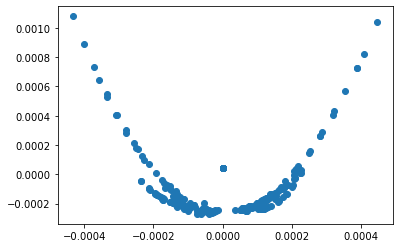

In [233]:
#call to build pairwise-dist matrix
d=distance_matrix(data, metric='cityblock')
A=adj_matrix(data,d,eps=200) # based on distance and epsilon bound
z=isomap(A)
# plot for principal compnent projection of every point
plt.scatter(z[:,0],z[:,1])

#### d. (10 points) Perform PCA (you can now use your implementation written in Question 1) on the imagesand project them into the top 2 principal components. Again show them on a scatter plot. Explain whether or you see a more meaningful projection using ISOMAP than PCA.

In [234]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
z = pca.fit_transform(data)

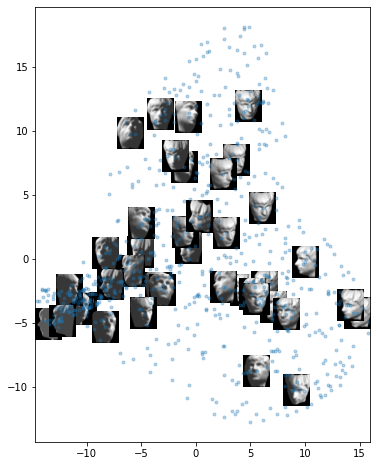

In [235]:
x_size = (max(z[:, 0]) - min(z[:, 0])) *.08
y_size = (max(z[:, 1]) - min(z[:, 1])) *.08

fig = plt.figure()
fig.set_size_inches(6,8)

ax=fig.add_subplot()


for i in range(40):
    x0 = z[i, 0] - (x_size / 2.)
    x1 = z[i, 0] + (x_size / 2.)        
    y0 = z[i, 1] - (y_size / 2.)    
    y1 = z[i, 1] + (y_size / 2.)        

    img = data[i,:].reshape(64,64).T
    ax.imshow(img,cmap=plt.cm.gray,aspect='auto',extent=(x0, x1, y0, y1))
#print(x0,x1,y0,y1)
ax.scatter(z[:,0],z[:,1],marker='.',alpha=.3,)

comparing both the dataset in this case does not show much difference considering the impage space and distances do not differ much between geodesic and euclidean.  Still ISOMAP  projection shows picture much clustered and facial direction more clustered togerther. Theoretically, ISOMAP will performa better in tersm of accuracy where geodesic distance is more meaningful than euclidean , such as swiss-role scenario.

#### 4. PCA: Food consumption in European countries [Bonus Question: 5 points]

In [236]:
import pandas as pd
with open ('data'+os.path.sep+'food-consumption.csv') as f:
    foodDF=pd.read_csv(f)
foodDF
    

,Country,Real coffee,Instant coffee,Tea,Sweetener,Biscuits,Powder soup,Tin soup,Potatoes,Frozen fish,...,Apples,Oranges,Tinned fruit,Jam,Garlic,Butter,Margarine,Olive oil,Yoghurt,Crisp bread
0,Germany,90,49,88,19,57,51,19,21,27,...,81,75,44,71,22,91,85,74,30,26
1,Italy,82,10,60,2,55,41,3,2,4,...,67,71,9,46,80,66,24,94,5,18
2,France,88,42,63,4,76,53,11,23,11,...,87,84,40,45,88,94,47,36,57,3
3,Holland,96,62,98,32,62,67,43,7,14,...,83,89,61,81,15,31,97,13,53,15
4,Belgium,94,38,48,11,74,37,23,9,13,...,76,76,42,57,29,84,80,83,20,5
5,Luxembourg,97,61,86,28,79,73,12,7,26,...,85,94,83,20,91,94,94,84,31,24
6,England,27,86,99,22,91,55,76,17,20,...,76,68,89,91,11,95,94,57,11,28
7,Portugal,72,26,77,2,22,34,1,5,20,...,22,51,8,16,89,65,78,92,6,9
8,Austria,55,31,61,15,29,33,1,5,15,...,49,42,14,41,51,51,72,28,13,11
9,Switzerland,73,72,85,25,31,69,10,17,19,...,79,70,46,61,64,82,48,61,48,30


In [237]:
# Scale the data - except country
from sklearn.preprocessing import StandardScaler
m=foodDF.loc[:,foodDF.columns!='Country']
X_scaled = StandardScaler().fit_transform(m.to_numpy())
print(X_scaled.shape)
print(X_scaled[:5])


(16, 20)
[[ 0.51035553  0.43502841  0.5292089   0.09805807 -0.19868248  0.13389239
   0.0351887   0.88994382  0.37860853  0.41384595  0.8334387   0.33118241
   0.09159355  0.72284829 -0.60497294  0.7501465   0.61064044  0.70944571
   0.53153529 -0.0722187 ]
 [ 0.15338554 -1.30508524 -1.03056471 -1.56892908 -0.30644247 -0.53556954
  -0.78374824 -1.15962376 -1.32051268 -1.12041219  0.01101461  0.03679805
  -1.46272121 -0.41999486  1.12245749 -0.48466256 -1.73575747  1.42560542
  -0.87650522 -0.40236131]
 [ 0.42111303  0.12270032 -0.86344611 -1.37281295  0.82503743  0.26778477
  -0.37427977  1.10568777 -0.80338883 -0.87816091  1.18590616  0.99354722
  -0.08604242 -0.46570858  1.36072375  0.89832359 -0.85105006 -0.65125773
   2.05221905 -1.02137871]
 [ 0.77808302  1.0150663   1.08627091  1.37281295  0.07071749  1.20503147
   1.2635941  -0.62026387 -0.58176433 -0.15140705  0.95092785  1.36152768
   0.84654643  1.17998555 -0.81345592 -2.21339524  1.07222692 -1.4748414
   1.82693257 -0.526164

In [238]:
#Build covariance metrics
features =X_scaled.T
cov_matrix = np.cov(features)
print(cov_matrix.shape)
cov_matrix[:5]

(20, 20)


array([[ 1.06666667, -0.50732067, -0.12602399,  0.26923746, -0.08289456,
        -0.27084152, -0.28941445,  0.26000287,  0.42350337,  0.32167433,
         0.25717802,  0.59494217, -0.10970548, -0.37949695,  0.07559055,
        -0.11376968,  0.28055668, -0.0155186 ,  0.3189909 ,  0.37764495],
       [-0.50732067,  1.06666667,  0.31035808,  0.25813587,  0.28916519,
         0.77563088,  0.5419656 , -0.02406532, -0.31126827, -0.06881628,
         0.51281491,  0.26817148,  0.74122881,  0.4087836 ,  0.0358576 ,
         0.16524851,  0.18140942,  0.08012422,  0.53505424, -0.43246005],
       [-0.12602399,  0.31035808,  1.06666667,  0.56481654,  0.21540405,
         0.47063993,  0.5709136 ,  0.16865647,  0.34211747,  0.51040706,
         0.14235102,  0.02705841,  0.582923  ,  0.57441408, -0.63339425,
         0.32256293,  0.26213208, -0.51231234,  0.00282372,  0.44031097],
       [ 0.26923746,  0.25813587,  0.56481654,  1.06666667,  0.20006354,
         0.21838284,  0.4868392 ,  0.33496106,  

In [239]:
#eigenDecomposition
evals,evecs = np.linalg.eig(cov_matrix)
print(evecs.shape)
evals[:5]

(20, 20)


array([6.68222585+0.j, 4.08943029+0.j, 2.92687393+0.j, 1.66867475+0.j,
       1.35695556+0.j])

In [240]:
# a quick check as how eigen values explains variances cumulatively
explained_variances = []
for i in range(len(evals)-1,-1,-1):
    explained_variances.append((evals[i] / np.sum(evals)).real)

print(np.sum(explained_variances), '\n', explained_variances)

1.0 
 [1.3065196761561607e-19, 1.3065196761561607e-19, 3.244414052562095e-18, -1.0074481377152728e-17, -1.6558245061306658e-17, 0.0004987422334778676, 0.002589322095196513, 0.005439669523154026, 0.01032819437430582, 0.011992055152953198, 0.01912780949908082, 0.026940083710374194, 0.03368386521450657, 0.0470757483179822, 0.05837949246562185, 0.06360729193582437, 0.07821912900811871, 0.13719721529626555, 0.19169204466812872, 0.3132293365050096]


In [241]:
print(evecs.shape)
print(X_scaled.shape)

(20, 20)
(16, 20)


In [242]:
projected_1 = X_scaled.dot(evecs.T[0]).real
projected_2 = X_scaled.dot(evecs.T[1]).real

In [243]:
res = pd.DataFrame(projected_1, columns=['PC1'])
res['PC2'] = projected_2
res['Y'] = foodDF['Country']
res.head()

,PC1,PC2,Y
0,-1.367767,-0.118310,Germany
1,3.747875,-0.431793,Italy
2,0.614815,-2.316402,France
3,-2.738056,-1.776824,Holland
4,0.767776,-0.840030,Belgium


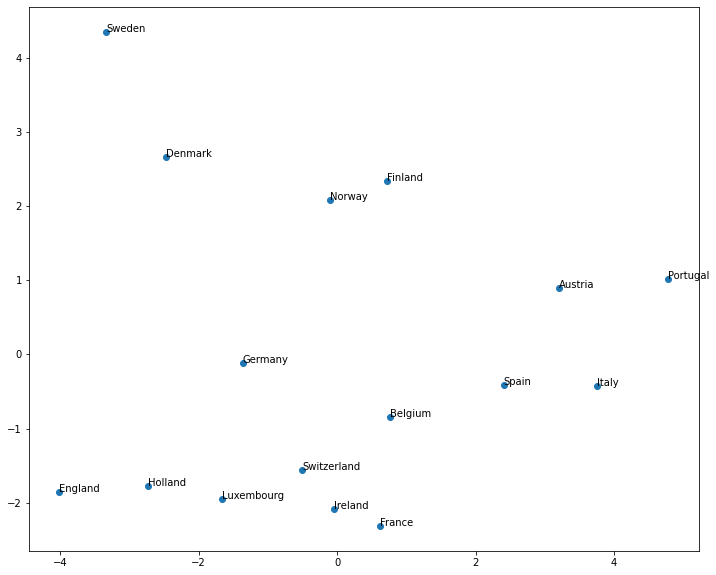

In [244]:
fig, ax = plt.subplots(figsize=(12,10))
x,y=res['PC1'], res['PC2']
ax.scatter(x,y)

for i, txt in enumerate(res['Y']):
    ax.annotate(txt, (x[i], y[i]))
